# Meteorological data processing
To create the main input file for a environmental profile/tracking experiment

Output should be table of (datetime, air temp, RH, sun angle)

In [1]:
import sys
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

import scipy.interpolate
import pandas as pd
import dateutil
import ftplib
import io
import datetime
import time
import requests
import ephem

# import statsmodels.formula.api as smformula
from collections import OrderedDict

from IPython.display import display, HTML
%matplotlib notebook
plt.style.use('seaborn-paper')

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# ISD LITE data
GHCND does not contain information about humidity, so we have to use a different data source.  
ISD (and ISD LITE) should have hourly temperatures and dewpoints, but aren't nearly as well quality controled as GHCND daily summaries.  
ISD is also nominally hourly, but some stations, especially long ago, didn't report every hour and there are often big gaps.

In [3]:
NOAA_ISD_ftp_host = 'ftp.ncdc.noaa.gov'
DATADIR = 'ISD'

### We use ISD LITE data for Med-Foes runs, so I've got some functions for dealing with it already

In [4]:
def temp2vp(T):
    """Convert a temperature in Celcius to vapor pressure in pascals
    from:
    http://www.npl.co.uk/reference/faqs/how-do-i-convert-between-units-of-dew-point-and-relative-humidity-(faq-thermal)
    equation 4: vapour pressure in pascals from dewpoint in kelvin for water
    """
    T = T + 273.15 # to kelvin
    e = np.exp(-6096.9385/T + 21.2409642 - 2.711193e-2*T + 1.673952e-5*T*T + 2.433502*np.log(T))
    return e


In [5]:
ISD_LITE_SPEC = [
    [( 0, 4), 'year', int],
    [( 5, 7), 'month', int],
    [( 8,10), 'day', int],
    [(11,13), 'hour', int],
    [(13,19), 'air temp', lambda x: np.nan if x.strip()=='-9999' else int(x)/10],
    [(19,25), 'dewpoint', lambda x: np.nan if x.strip()=='-9999' else int(x)/10],
    [(25,31), 'sea level pressure', lambda x: np.nan if x=='-9999' else int(x)/10],
    [(31,37), 'wind direction', lambda x: np.nan if x=='-9999' else int(x)],
    [(37,43), 'wind speed', lambda x: np.nan if x=='-9999' else int(x)/10],
    [(43,49), 'sky condition total coverage code', lambda x: np.nan if x=='-9999' else int(x)],
    [(49,55), 'liquid percip 1hr', lambda x: np.nan if x=='-9999' else int(x)/10],
    [(55,61), 'liquid percip 6hr', lambda x: np.nan if x=='-9999' else int(x)/10],
    ]

In [6]:
def get_ISD_history_file(datadir, NOAA_ISD_ftp_host='ftp.ncdc.noaa.gov', save_file=True, force_download=False):
    ## get (fetch or load cached) isd-history.txt file
    tmp = None
    if not force_download: # try to load cached isd-history file
        try:
            tmp = read_isd_history_stations_list(os.path.join(datadir, 'isd-history.txt'))
        except FileNotFoundError:
            pass
    if tmp is None: # fetch
        logging.info("Fetching isd-history.txt")
        with ftplib.FTP(host=NOAA_ISD_ftp_host) as ftpconn:
            ftpconn.login()
            ftp_file = "/pub/data/noaa/isd-history.txt"
            # read the whole file and save it to a BytesIO (stream)
            response = io.BytesIO()
            try:
                ftpconn.retrbinary('RETR ' + ftp_file, response.write)
            except ftplib.error_perm as err:
                if str(err).startswith('550 '):
                    logging.error(err)
                else:
                    raise
        if save_file:
            response.seek(0)  # jump back to the beginning of the stream
            os.makedirs(datadir, exist_ok=True)
            with open(os.path.join(datadir, 'isd-history.txt'),'wb') as fh:
                fh.write(response.getvalue())
        response.seek(0)  # jump back to the beginning of the stream
        tmp = read_isd_history_stations_list(response)
    return tmp


def read_isd_history_stations_list(filename, skiprows=22):
    """Read and parse stations information from isd_history.txt file"""
    fwfdef = (( ('USAF', (6, str)),
                ('WBAN', (5, str)),
                ('STATION NAME', (28, str)),
                ('CTRY', (4, str)),
                ('ST', (2, str)),
                ('CALL', (5, str)),
                ('LAT', (7, str)),
                ('LON', (8, str)),
                ('EVEV', (7, str)),
                ('BEGIN', (8, str)),
                ('END', (8, str)),
                ))
    names = []
    colspecs = []
    converters = {}
    i = 0
    for k,v in fwfdef:
        names.append(k)
        colspecs.append((i, i+v[0]+1))
        i += v[0]+1
        converters[k] = v[1]
    stdf = pd.read_fwf(filename, skiprows=skiprows,
                       names=names,
                       colspecs=colspecs,
                       converters=converters)
    return stdf

In [7]:
def fetch_isd_by_callsign(sitename,
                          station_callsign,
                          datadir,
                          first_year=None,
                          NOAA_ISD_ftp_host='ftp.ncdc.noaa.gov',
                          ISD_LITE_FTP_BASE_PATH="/pub/data/noaa/isd-lite",
                          force_download=False):
    os.makedirs(datadir, exist_ok=True)
    now_year = datetime.datetime.now().year
    # get the isd_history (aka station_info)
    station_info = get_ISD_history_file(datadir, NOAA_ISD_ftp_host, save_file=True,
                                     force_download=force_download)
    # pick just the info associated with the station we want
    station_info = station_info[station_info['CALL'] == station_callsign]
    logging.info("Station info for "+station_callsign+"\n"+str(station_info))
    fetch_isd_by_ids(sitename, None, datadir, first_year,
                     NOAA_ISD_ftp_host, ISD_LITE_FTP_BASE_PATH, force_download,
                     _station_info=station_info)
    return list(zip(*[station_info['USAF'].astype(str), station_info['WBAN'].astype(str)]))
    
def fetch_isd_by_ids(sitename,
                     isd_station_ids,
                     datadir,
                     first_year=None,
                     NOAA_ISD_ftp_host='ftp.ncdc.noaa.gov',
                     ISD_LITE_FTP_BASE_PATH="/pub/data/noaa/isd-lite",
                     force_download=False,
                     _station_info=None):
    now_year = datetime.datetime.now().year
    if _station_info is None:
        os.makedirs(datadir, exist_ok=True)

        # get the isd_history (aka station_info)
        station_info = get_ISD_history_file(datadir, NOAA_ISD_ftp_host, save_file=True,
                                         force_download=force_download)
        # pick just the info associated with the stations (USAF,WBAN) list we want
        station_info = station_info.loc[(station_info['USAF'].astype(str) + station_info['WBAN'].astype(str)).isin([ str(x)+str(y) for x,y in isd_station_ids ])]
        logging.info("Station info for "+sitename+"\n"+str(station_info))
    else:
        station_info = _station_info

    # load the last fetch timestamp
    last_fetch_time = None
    print(datadir)
    last_fetch_fn = os.path.join(datadir, "last_fetch_time_{}.txt".format(sitename))
    if not force_download:
        try:
            with open(last_fetch_fn, 'r') as fh:
                last_fetch_time = fh.readline().strip()
                last_fetch_time = time.strptime(last_fetch_time, "%Y-%m-%dT%H:%M:%S%z")
        except FileNotFoundError:
            logging.info("No '{}' file found".format(last_fetch_fn))
            last_fetch_time = None
            pass
        except ValueError as err:
            logging.error("Did not understand '{}': {}".format(last_fetch_fn, str(err)))
            last_fetch_time = None

    isd_files = []
    to_get = []
    for k, row in station_info.iterrows():
        for year in range(int(row['BEGIN'][0:4]), int(row['END'][0:4])+2):  # +2 because isd-history may be out of date
            if first_year is None or year >= first_year:
                if year <= now_year:
                    isd_files.append([year, "{}-{}-{:04d}.gz".format(row['USAF'], row['WBAN'], year)])
                    if last_fetch_time is None or year >= last_fetch_time.tm_year:
                        to_get.append(isd_files[-1])

    logging.info("Number of possible ISD files = {:d}".format(len(isd_files)))
    logging.info("Number of files try and get/update = {:d}".format(len(to_get)))

    ## Download isd-lite files
    # print(*to_get, sep="\n")
    if len(to_get) > 0:
        with ftplib.FTP(host=NOAA_ISD_ftp_host) as ftpconn:
            ftpconn.login()
            for year, fn in to_get:
                url = "{}/{:04d}/{}".format(ISD_LITE_FTP_BASE_PATH,year,fn)
                logging.info("Fetching: '{}'".format(url))
                has_err = False
                with open(os.path.join(datadir, fn), 'wb') as fh:
                    try:
                        ftpconn.retrbinary('RETR ' + url, fh.write)
                    except ftplib.error_perm as err:
                        has_err = True
                        if str(err).startswith('550 '):
                            logging.warning(err)
                        else:
                            raise
                if has_err:
                    os.remove(os.path.join(datadir, fn))

    # save the timestamp to a file
    with open(last_fetch_fn, 'w') as fh:
        print(time.strftime("%Y-%m-%dT%H:%M:%S%z"), file=fh)

In [8]:
historydf = get_ISD_history_file(DATADIR, NOAA_ISD_ftp_host)

## Pick the stations
We merge all the data for stations in the ISD_STATION_IDS list and just take the first value if there are duplicates.  
Also need the timezone to convert from UTC to local

In [9]:
# SITENAME = "SunValley"
# CALLSIGN = 'KBUR'
# START_DATE = "2017-08-26"

SITENAME = "HalfMoonBay"
CALLSIGN = 'KHAF'
START_DATE = "2017-11-22"

LOCAL_TIME_OFFSET = '-08:00'
END_DATE = None
FIRST_YEAR = pd.to_datetime(START_DATE).year

### Actually downloading the ISD LITE datafiles
This tries to be clever and only downloads files we are missing or might have new data

In [10]:
# # fetch_isd_by_callsign(CALLSIGN, DATADIR)
# ISD_STATION_IDS = [ # (USAF, WBAN) pairs
# (722520, 12907), # LAREDO INTERNATIONAL AIRPORT   US  TX  KLRD  +27.533   -099.467 	+0150.6 	20081124 	20180115
# (722520, 12920), #          LAREDO INTL AIRPORT   US  TX  KLRD  +27.550   -099.467 	+0155.0 	19650301 	19991231
# (722520, 99999), #          LAREDO INTL AIRPORT   US  TX  KLRD  +27.550   -099.467 	+0155.0 	19430101 	20081123
# (722525, 12920), #        LAREDO AIR FORCE BASE   US  TX  KLRD  +27.544   -099.461 	+0154.8 	19460806 	19650315
# (999999, 12907), #                   LAREDO AFB   US  TX  KLRD  +27.533   -099.467 	+0154.8 	20040702 	20081123
# (722521, 99999), #                  LAREDO INTL   US  TX        +27.617   -099.517   +0164.0     19760824    19790727
# ]
# station_info = get_ISD_history_file(datadir, NOAA_ISD_ftp_host)
# display(station_info.loc[(station_info['USAF'].astype(str) + station_info['WBAN'].astype(str)).isin([ str(x)+str(y) for x,y in ISD_STATION_IDS ])])
# fetch_isd_by_ids(SITENAME, ISD_STATION_IDS, DATADIR)
ISD_STATION_IDS = fetch_isd_by_callsign(SITENAME, CALLSIGN, DATADIR, FIRST_YEAR)

INFO:root:Station info for KHAF
         USAF   WBAN           STATION NAME CTRY  ST  CALL      LAT       LON  \
17583  720646  00228  HALF MOON BAY AIRPORT   US  CA  KHAF  +37.513  -122.501   
17584  720646  99999  HALF MOON BAY AIRPORT   US  CA  KHAF  +37.513  -122.501   

          EVEV     BEGIN       END  
17583  +0020.1  20130101  20180318  
17584  +0020.4  20090717  20170522  
INFO:root:No 'ISD/last_fetch_time_HalfMoonBay.txt' file found
INFO:root:Number of possible ISD files = 4
INFO:root:Number of files try and get/update = 4


ISD


INFO:root:Fetching: '/pub/data/noaa/isd-lite/2017/720646-00228-2017.gz'
INFO:root:Fetching: '/pub/data/noaa/isd-lite/2018/720646-00228-2018.gz'
INFO:root:Fetching: '/pub/data/noaa/isd-lite/2017/720646-99999-2017.gz'
INFO:root:Fetching: '/pub/data/noaa/isd-lite/2018/720646-99999-2018.gz'


### Read data from the raw ISD LITE files

In [11]:
isd_files = []
for usaf,wban in ISD_STATION_IDS:
    print(usaf,wban)
    tmp = glob.glob(os.path.join(DATADIR, '{}-{}-*.gz'.format(usaf, wban)))
    if tmp:
        isd_files.extend(tmp)
print(isd_files)

720646 00228
720646 99999
['ISD/720646-00228-2017.gz', 'ISD/720646-00228-2018.gz', 'ISD/720646-99999-2017.gz']


In [12]:
## Load the isd-lite data from files
tempdf = None
for fn in isd_files:
    print(fn)
    try:
        d = pd.read_fwf(os.path.join(fn),
                        colspecs=[x[0] for x in ISD_LITE_SPEC],
                        names=[x[1] for x in ISD_LITE_SPEC],
                        converters=OrderedDict([[x[1], x[2]] for x in ISD_LITE_SPEC]),
                        compression='infer')
        if tempdf is None:
            tempdf = d
        else:
            tempdf = pd.concat([tempdf, d])
    except FileNotFoundError:
        logging.warning("File not found: '{}'".format(fn))
        pass
# make a datetime index
tempdf.index = pd.to_datetime(tempdf[['year', 'month', 'day', 'hour']])
tempdf.index = tempdf.index.tz_localize('UTC')
# sort
tempdf.sort_index(inplace=True)

# localize times
tmp = LOCAL_TIME_OFFSET.split(':')
tmp = int(tmp[0])*3600+int(tmp[1])*60
sitetz = dateutil.tz.tzoffset(LOCAL_TIME_OFFSET, tmp)
tempdf.index = tempdf.index.tz_convert(sitetz)

ISD/720646-00228-2017.gz
ISD/720646-00228-2018.gz
ISD/720646-99999-2017.gz


In [13]:
tempdf

,year,month,day,hour,air temp,dewpoint,sea level pressure,wind direction,wind speed,sky condition total coverage code,liquid percip 1hr,liquid percip 6hr
2016-12-31 19:00:00-08:00,2017,1,1,3,6.0,3.0,NaN,0.0,0.0,2.0,NaN,NaN
2016-12-31 20:00:00-08:00,2017,1,1,4,5.0,3.0,NaN,0.0,0.0,2.0,NaN,NaN
2017-01-01 00:00:00-08:00,2017,1,1,8,10.0,8.0,NaN,310.0,6.7,NaN,NaN,NaN
2017-01-01 01:00:00-08:00,2017,1,1,9,10.0,7.0,NaN,300.0,6.7,NaN,NaN,NaN
2017-01-01 02:00:00-08:00,2017,1,1,10,10.0,7.0,NaN,320.0,7.7,NaN,NaN,NaN
2017-01-01 03:00:00-08:00,2017,1,1,11,10.0,5.0,NaN,320.0,9.3,NaN,NaN,NaN
2017-01-01 04:00:00-08:00,2017,1,1,12,10.0,5.0,NaN,320.0,6.2,NaN,NaN,NaN
2017-01-01 05:00:00-08:00,2017,1,1,13,9.0,5.0,NaN,320.0,7.7,NaN,NaN,NaN
2017-01-01 06:00:00-08:00,2017,1,1,14,10.0,5.0,NaN,320.0,5.7,NaN,NaN,NaN
2017-01-01 07:00:00-08:00,2017,1,1,15,9.0,5.0,NaN,310.0,5.1,NaN,NaN,NaN


<IPython.core.display.Javascript object>


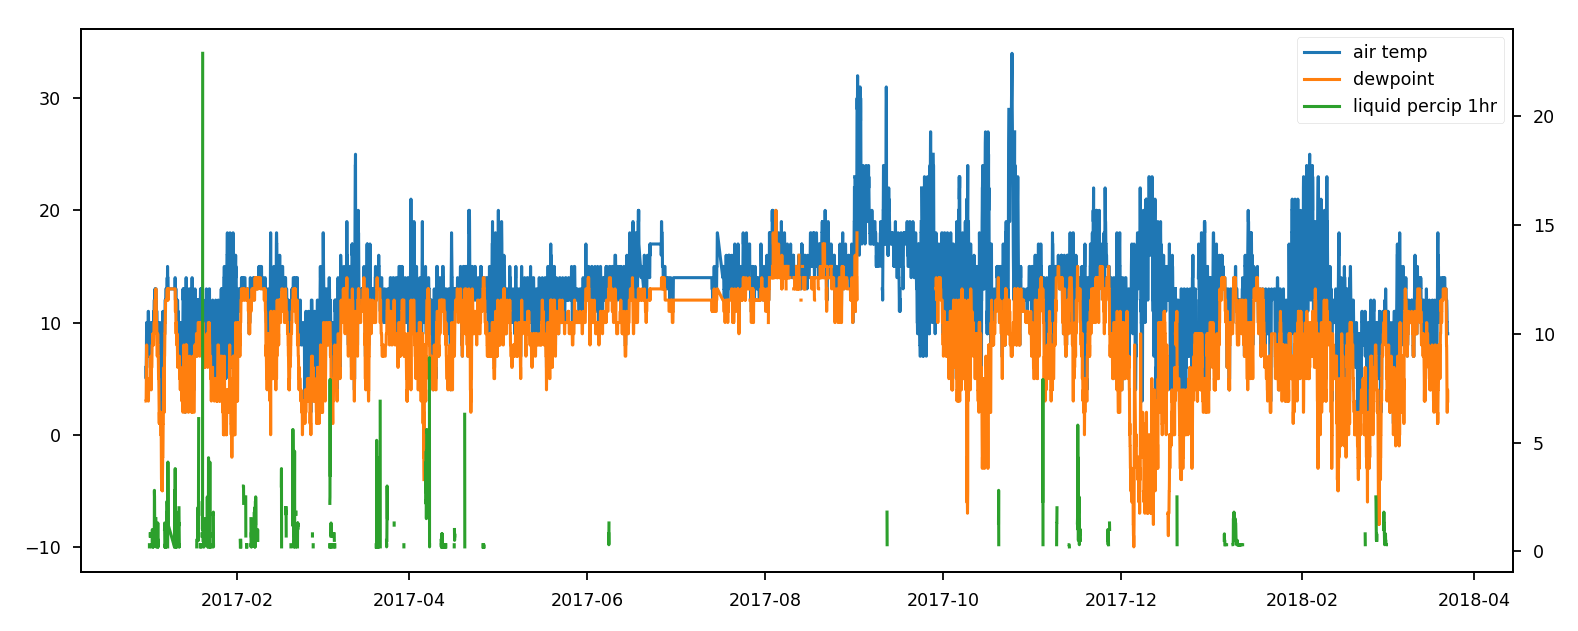

In [14]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.plot(t.index, t['air temp'])#, marker='x', mew=1)
ax.plot(t.index, t['dewpoint'])#, marker='+', mew=1)
ax2.plot(t.index, t['liquid percip 1hr'], 'C2')

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()

### Trim to just the dates we want

In [15]:
fulldf = tempdf.copy(deep=True)
if END_DATE is None:
    tempdf = tempdf[START_DATE:]
else:
    tempdf = tempdf[START_DATE:END_DATE]
tempdf.index.name = 'datetime'

### Cleanup data a bit (remove spurious temps and dewpoints at least)
@TCC More cleanup is probably in order here... Must at least check carefully

<IPython.core.display.Javascript object>


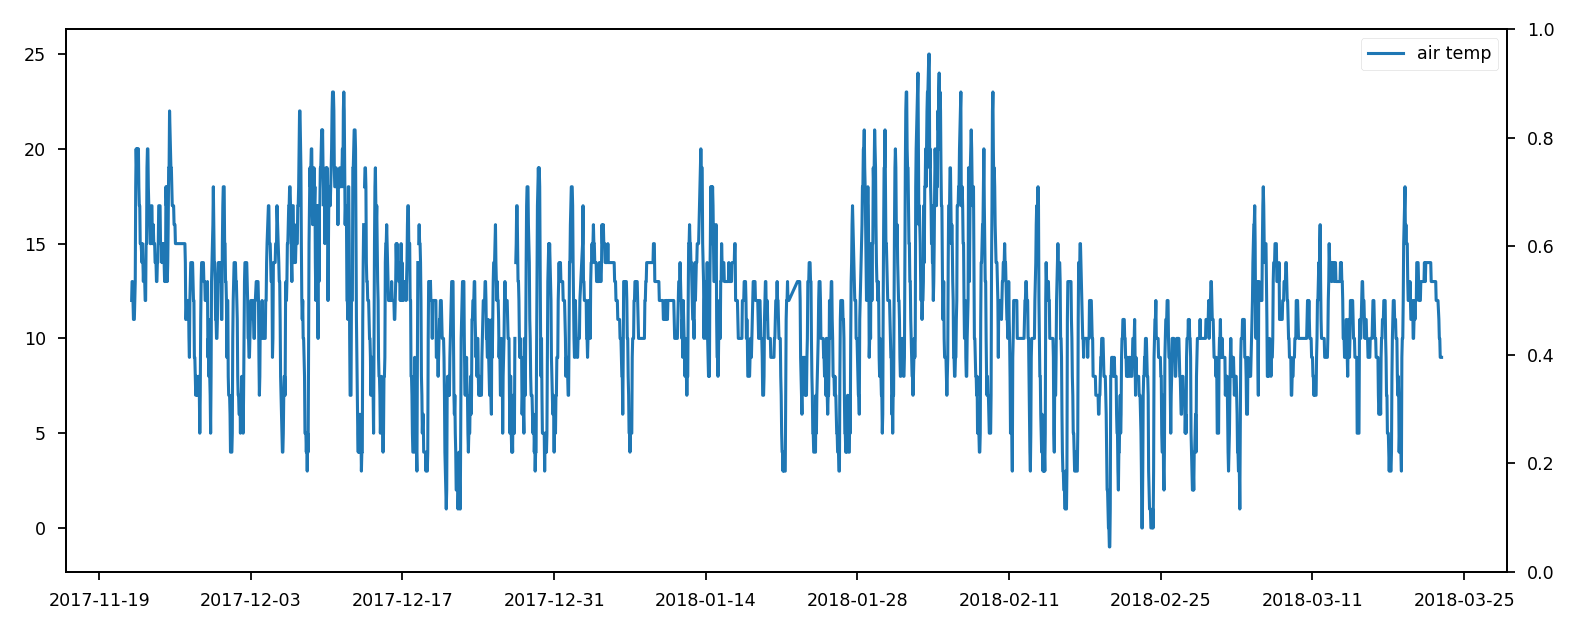

In [16]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.plot(t.index, t['air temp'])#, marker='x', mew=1)
# ax.plot(t.index, t['dewpoint'])#, marker='+', mew=1)
# ax2.plot(t.index, t['liquid percip 1hr'], 'C2')

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()

### Resample (possibly upsample and interpolate)

In [17]:
RESAMP_FREQ = '15min'
INTERP_METHOD = 'pchip'
t = tempdf.copy(deep=True)
t = t.resample(RESAMP_FREQ).interpolate(method=INTERP_METHOD)
tempdf = t

<IPython.core.display.Javascript object>


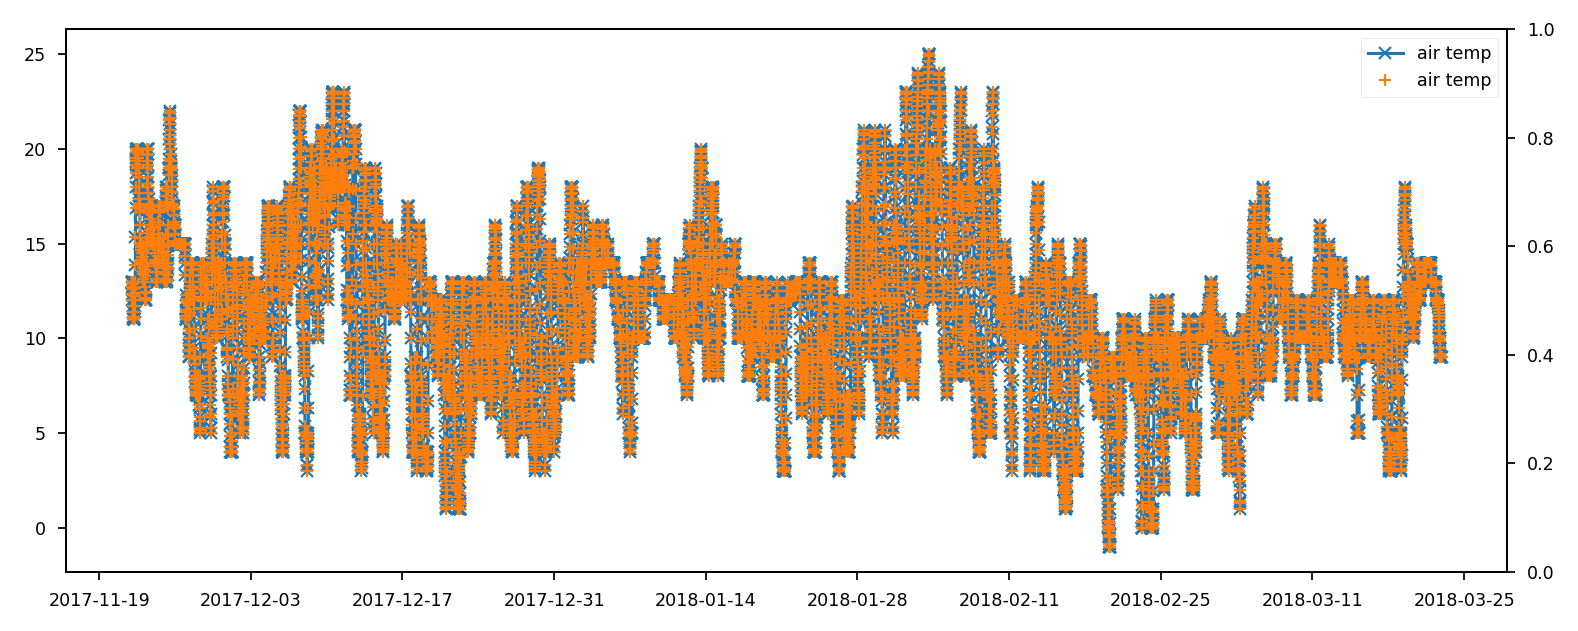

In [18]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.plot(t.index, t['air temp'], marker='x', mew=1)
ax.plot(tempdf.index, tempdf['air temp'], ls='none', marker='+', mew=1, mfc='none')
# ax.plot(t.index, t['dewpoint'])#, marker='+', mew=1)
# ax2.plot(t.index, t['liquid percip 1hr'], 'C2')

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()

In [19]:
# investigating the temperature diff/step sizes
t['air temp'].diff().describe()

count    11608.000000
mean        -0.000258
std          0.399871
min         -2.062500
25%         -0.170072
50%          0.000000
75%          0.125901
max          2.561111
Name: air temp, dtype: float64

In [20]:
t.loc[t['air temp'].diff().idxmax()]

year                                 2018.000000
month                                   2.000000
day                                     2.000000
hour                                   16.750000
air temp                               16.383333
dewpoint                                8.890625
sea level pressure                           NaN
wind direction                         21.937500
wind speed                              3.881250
sky condition total coverage code       0.000000
liquid percip 1hr                       0.337932
liquid percip 6hr                            NaN
Name: 2018-02-02 08:45:00-08:00, dtype: float64

### Add VPD and RH columns

In [21]:
es = temp2vp(tempdf['air temp'])
e = temp2vp(tempdf['dewpoint'])
tempdf['RH'] = 100*e/es
tempdf['VPD'] = (es - e)/1000.0 # in Kpa
tempdf

,year,month,day,hour,air temp,dewpoint,sea level pressure,wind direction,wind speed,sky condition total coverage code,liquid percip 1hr,liquid percip 6hr,RH,VPD
datetime,,,,,,,,,,,,,,
2017-11-22 00:00:00-08:00,2017.0,11.0,22.000000,8.000000,12.000000,10.000000,NaN,0.000000,0.000000,0.00000,NaN,NaN,87.550301,0.174641
2017-11-22 00:15:00-08:00,2017.0,11.0,22.000000,8.250000,12.367188,10.804688,NaN,0.000000,0.000000,0.00000,NaN,NaN,90.177536,0.141160
2017-11-22 00:30:00-08:00,2017.0,11.0,22.000000,8.500000,12.687500,11.437500,NaN,0.000000,0.000000,0.00000,NaN,NaN,92.090369,0.116087
2017-11-22 00:45:00-08:00,2017.0,11.0,22.000000,8.750000,12.914062,11.851562,NaN,0.000000,0.000000,0.00000,NaN,NaN,93.252214,0.100516
2017-11-22 01:00:00-08:00,2017.0,11.0,22.000000,9.000000,13.000000,12.000000,NaN,0.000000,0.000000,0.00000,NaN,NaN,93.641934,0.095245
2017-11-22 01:15:00-08:00,2017.0,11.0,22.000000,9.250000,13.000000,11.890625,NaN,46.875000,0.234375,0.00000,NaN,NaN,92.968587,0.105332
2017-11-22 01:30:00-08:00,2017.0,11.0,22.000000,9.500000,13.000000,11.625000,NaN,150.000000,0.750000,0.00000,NaN,NaN,91.351022,0.129563
2017-11-22 01:45:00-08:00,2017.0,11.0,22.000000,9.750000,13.000000,11.296875,NaN,253.125000,1.265625,0.00000,NaN,NaN,89.387089,0.158983
2017-11-22 02:00:00-08:00,2017.0,11.0,22.000000,10.000000,13.000000,11.000000,NaN,300.000000,1.500000,0.00000,NaN,NaN,87.642324,0.185120


<IPython.core.display.Javascript object>


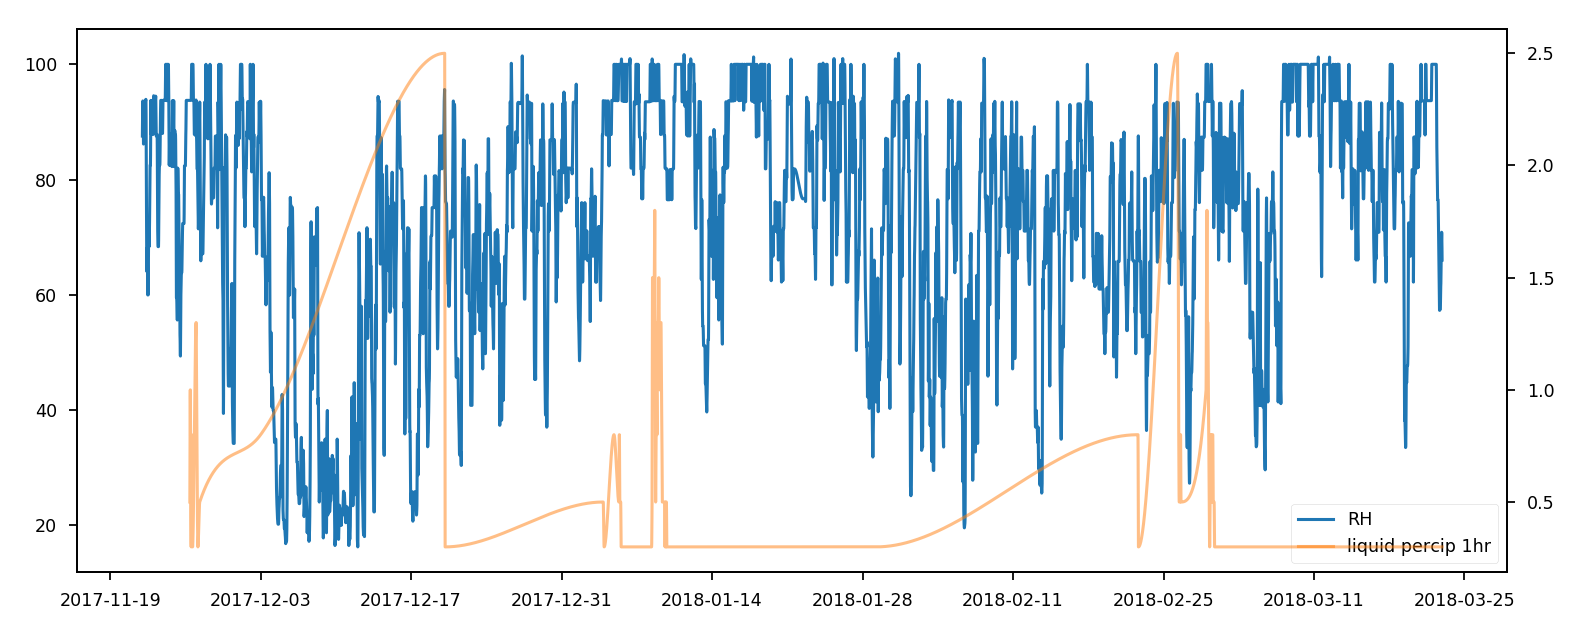

In [22]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.plot(t.index, t['RH'], c='C0')
# ax2.plot(t.index, t['VPD'], c='C1', alpha=0.5)
ax2.plot(t.index, t['liquid percip 1hr'], 'C1', alpha=0.5)

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()

### Add column for sun angle
For now just treated as <=thresh is off, >thresh is on, may implement as light level eventually
-6 degrees (civil twilight) is probably a good threshold

In [23]:
# need lat and lon
station_info = get_ISD_history_file(DATADIR, NOAA_ISD_ftp_host)
station_info = station_info.loc[(station_info['USAF'].astype(str) + station_info['WBAN'].astype(str)).isin([ str(x)+str(y) for x,y in ISD_STATION_IDS ])]

# ephem uses a body and observer object, so make those
sun = ephem.Sun()
obs = ephem.Observer()
obs.lat = station_info['LAT'].astype(float).mean()
obs.lon = station_info['LON'].astype(float).mean()
obs.elevation = station_info['EVEV'].astype(float).mean()

def datetime2sunalt(d): # function to apply
    obs.date = d.tz_convert('UTC')
    sun.compute(obs)
    return sun.alt*180/np.pi

tempdf['sun angle'] = pd.Series(tempdf.index, index=tempdf.index).apply(datetime2sunalt)
tempdf

,year,month,day,hour,air temp,dewpoint,sea level pressure,wind direction,wind speed,sky condition total coverage code,liquid percip 1hr,liquid percip 6hr,RH,VPD,sun angle
datetime,,,,,,,,,,,,,,,
2017-11-22 00:00:00-08:00,2017.0,11.0,22.000000,8.000000,12.000000,10.000000,NaN,0.000000,0.000000,0.00000,NaN,NaN,87.550301,0.174641,-27.443989
2017-11-22 00:15:00-08:00,2017.0,11.0,22.000000,8.250000,12.367188,10.804688,NaN,0.000000,0.000000,0.00000,NaN,NaN,90.177536,0.141160,-30.620114
2017-11-22 00:30:00-08:00,2017.0,11.0,22.000000,8.500000,12.687500,11.437500,NaN,0.000000,0.000000,0.00000,NaN,NaN,92.090369,0.116087,-33.734888
2017-11-22 00:45:00-08:00,2017.0,11.0,22.000000,8.750000,12.914062,11.851562,NaN,0.000000,0.000000,0.00000,NaN,NaN,93.252214,0.100516,-36.777307
2017-11-22 01:00:00-08:00,2017.0,11.0,22.000000,9.000000,13.000000,12.000000,NaN,0.000000,0.000000,0.00000,NaN,NaN,93.641934,0.095245,-39.734021
2017-11-22 01:15:00-08:00,2017.0,11.0,22.000000,9.250000,13.000000,11.890625,NaN,46.875000,0.234375,0.00000,NaN,NaN,92.968587,0.105332,-42.588798
2017-11-22 01:30:00-08:00,2017.0,11.0,22.000000,9.500000,13.000000,11.625000,NaN,150.000000,0.750000,0.00000,NaN,NaN,91.351022,0.129563,-45.321905
2017-11-22 01:45:00-08:00,2017.0,11.0,22.000000,9.750000,13.000000,11.296875,NaN,253.125000,1.265625,0.00000,NaN,NaN,89.387089,0.158983,-47.909467
2017-11-22 02:00:00-08:00,2017.0,11.0,22.000000,10.000000,13.000000,11.000000,NaN,300.000000,1.500000,0.00000,NaN,NaN,87.642324,0.185120,-50.322839


<IPython.core.display.Javascript object>


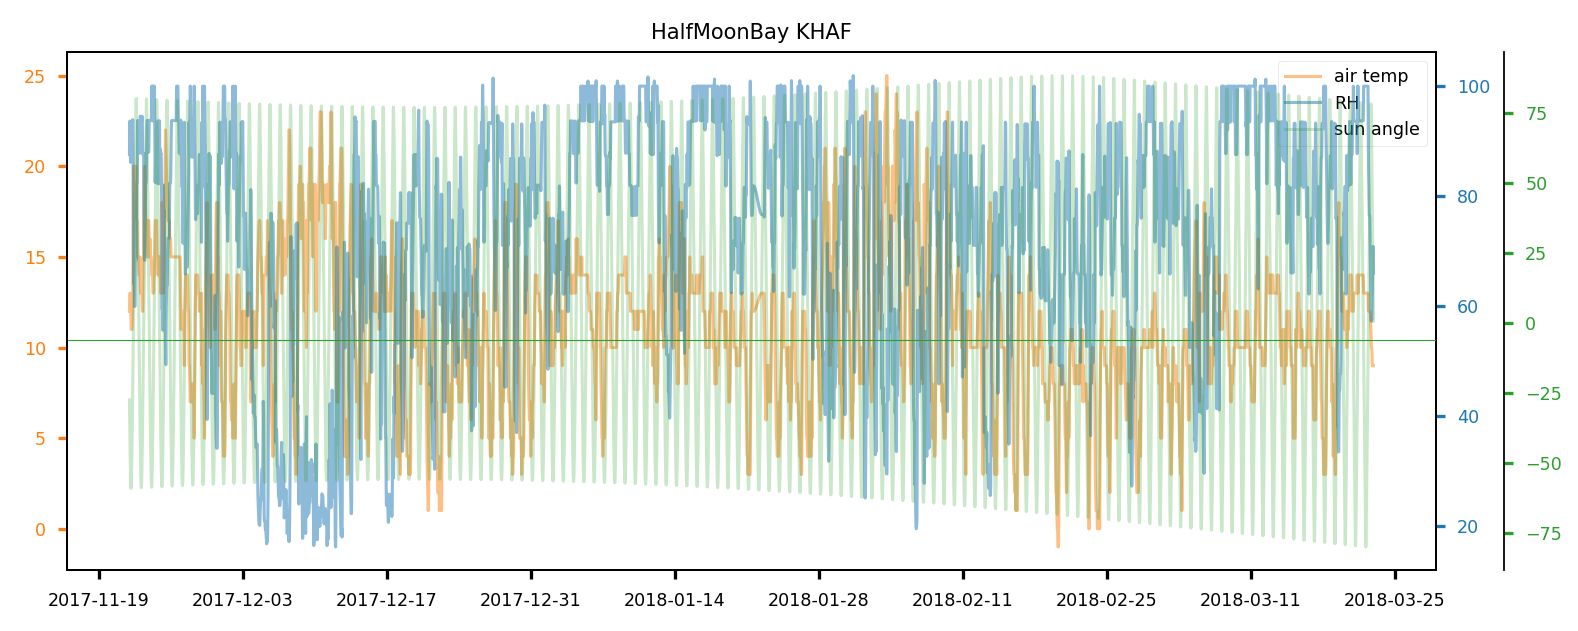

In [24]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax3 = ax.twinx()
p1, = ax.plot(t.index, t['air temp'], c='C1', alpha=0.5)
p2, = ax2.plot(t.index, t['RH'], c='C0', alpha=0.5)
p3, = ax3.plot(t.index, t['sun angle'], 'C2', alpha=0.25)
ax3.axhline(-6, ls='-', lw=.5, c='C2')

ax3.spines["right"].set_position(("axes", 1.05))

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())
tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax3.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.set_title(SITENAME+" "+CALLSIGN)
h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
h3,l3 = ax3.get_legend_handles_labels()
ax.legend(h1+h2+h3, l1+l2+l3)
fig.tight_layout()

<IPython.core.display.Javascript object>


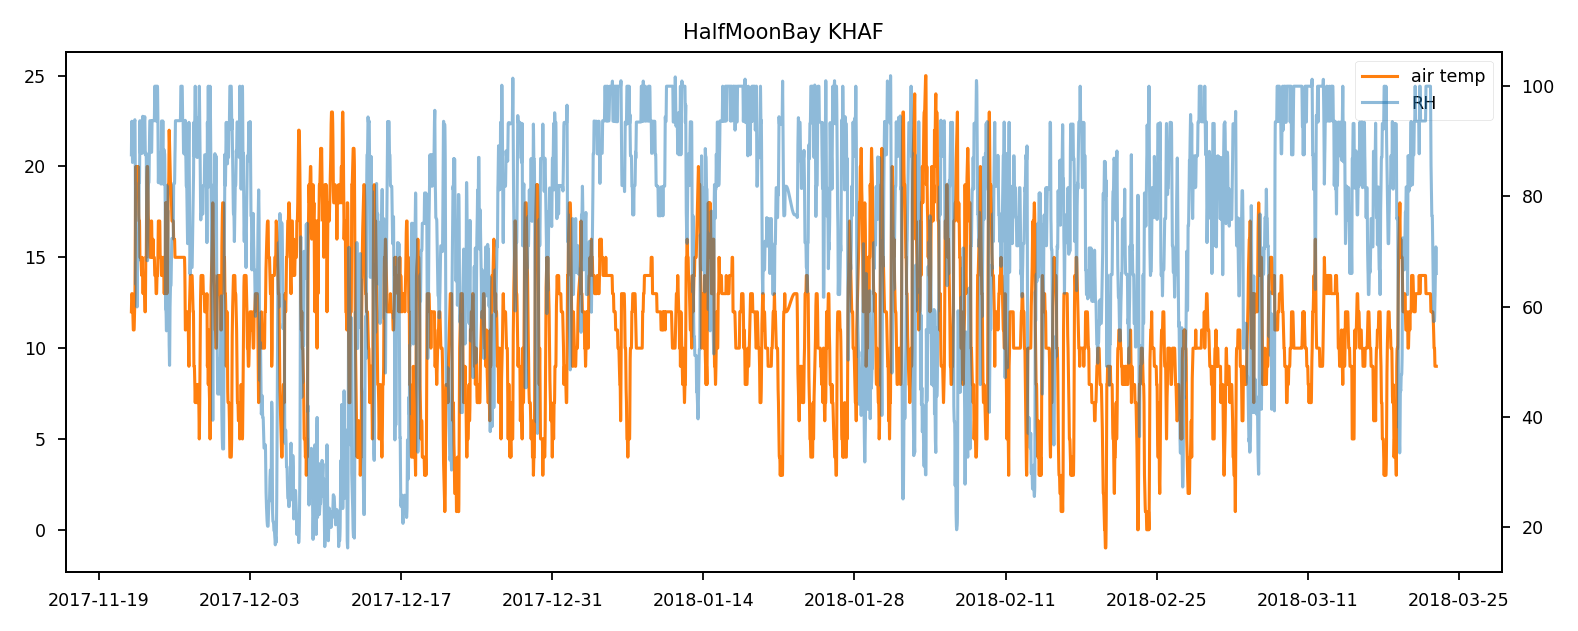

In [25]:
t = tempdf
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax2.plot(t.index, t['RH'], c='C0', alpha=0.5)
ax.plot(t.index, t['air temp'], c='C1')

ax.set_title(SITENAME+" "+CALLSIGN)
h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
fig.tight_layout()

### Save

In [26]:
# station info for the save file
station_info = get_ISD_history_file(DATADIR, NOAA_ISD_ftp_host)
station_info = station_info.loc[(station_info['USAF'].astype(str) + station_info['WBAN'].astype(str)).isin([ str(x)+str(y) for x,y in ISD_STATION_IDS ])]
display(station_info)

,USAF,WBAN,STATION NAME,CTRY,ST,CALL,LAT,LON,EVEV,BEGIN,END
17583,720646,00228,HALF MOON BAY AIRPORT,US,CA,KHAF,+37.513,-122.501,+0020.1,20130101,20180318
17584,720646,99999,HALF MOON BAY AIRPORT,US,CA,KHAF,+37.513,-122.501,+0020.4,20090717,20170522


In [27]:
out = tempdf[['air temp', 'RH', 'sun angle']]
out

,air temp,RH,sun angle
datetime,,,
2017-11-22 00:00:00-08:00,12.000000,87.550301,-27.443989
2017-11-22 00:15:00-08:00,12.367188,90.177536,-30.620114
2017-11-22 00:30:00-08:00,12.687500,92.090369,-33.734888
2017-11-22 00:45:00-08:00,12.914062,93.252214,-36.777307
2017-11-22 01:00:00-08:00,13.000000,93.641934,-39.734021
2017-11-22 01:15:00-08:00,13.000000,92.968587,-42.588798
2017-11-22 01:30:00-08:00,13.000000,91.351022,-45.321905
2017-11-22 01:45:00-08:00,13.000000,89.387089,-47.909467
2017-11-22 02:00:00-08:00,13.000000,87.642324,-50.322839


In [28]:
out.to_csv(SITENAME+'.csv')